# Analysis of Urban-Traffic Simulated Data – part II
##### Ruggero Fabbiano – <font color="blue">29 December 2020</font>

## Introduction

<font color="blue">

As the title itself says, this notebook is intended as a prosecution of the Analysis of Urban-Traffic Simulated Data – part I. While in this previous notebook we did some exploratory data analysis to get an understanding the data and of its basic population statistics, here we delve into some analysis about the traffic conditions.
    
The dataset is of the same type of the one used in part I; moreover, we assume it to have already gone through the Data Cleaning part of part I. The scenario is still the same (MoST), but this time we change the timing to have richer traffic conditions.

For further introduction, refer to part I.

</font>

 ***

## Import Packages and Data

Let's be sure we have all the necessary packages installed:

In [3]:
!pip install pandas
!pip install numpy
!pip install matplotlib

We can now import them:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')

Now to the data. We choose here the set spanning from 6 to 8:30 AM, to have some free flow as well as congested traffic conditions:

In [2]:
out_file = 'most_0600_0830_1_5.csv'

As explained in the introduction, we suppose to have previously run the part-I notebook with the same data set, thus we have it already available in its compact form (as the dataframe is saved after the part I "Data Cleaning" chapter).

In [3]:
out_file_clean = out_file.split(".")[0] + "-clean" + ".csv"
data = pd.read_csv(out_file_clean, low_memory=False)

data.head()

,t,angle,ID,lane_edge,position,slope,speed,v_type,x,y,z,time
0,21600.0,74.69,France:Italy.0,152525#0_0,7.2,3.42,0.0,hw_truck,66.77,2975.61,385.23,06:00:00
1,21600.0,171.94,Italy:France.0,152272_0,5.1,0.84,0.0,hw_passenger2b,7023.41,6356.52,280.47,06:00:00
2,21600.0,50.48,pedestrian_2-1_3985_tr,153330#1_1,2.2,-1.57,0.0,moped,4811.50,2704.21,143.81,06:00:00
3,21600.0,50.48,pedestrian_2-1_3985,153330#1,2.20,-1.55,0.00,NaN,4811.50,2704.21,143.81,06:00:00
4,21600.0,307.42,pedestrian_2-1_5063_tr,152413#3_1,2.3,-6.20,0.0,motorcycle,2006.06,3313.49,400.40,06:00:00


<font color="blue">

## Preparing the Vehicle Classes

</font>

To be able to infer meaningful information about traffic conditions it is probably better to work on the different vehicle types.

We might start off by dropping all the pedestrians, that won't probably be of much help in understanding traffic (maybe as well as bicycles). Anyway, let's just keep them for the moment, to see if they allow us some interesting comparisons (we can always drop them later); so, let's create a type for pedestrians as well:

In [4]:
data['v_type'].fillna('pedestrian', inplace=True) # pedestrians have null vehicle-type
data.rename(columns={'v_type': "type"}, inplace=True) # generic "type" and not "vehicle type" anymore

Now let's check which types we have:

In [5]:
np.sort(data['type'].unique())

array(['army', 'authority', 'avgbicycle', 'bus', 'coach', 'delivery',
       'emergency', 'fastbicycle', 'hw_coach', 'hw_delivery',
       'hw_motorcycle', 'hw_passenger1', 'hw_passenger2a',
       'hw_passenger2b', 'hw_passenger3', 'hw_passenger4', 'hw_trailer',
       'hw_truck', 'moped', 'motorcycle', 'passenger1', 'passenger2a',
       'passenger2b', 'passenger3', 'passenger4', 'pedestrian',
       'slowbicycle', 'taxi', 'trailer', 'train', 'truck', 'uber'],
      dtype=object)

Before starting reasoning on the different types, we can probably use a bit of manual regrouping to make things easier. To understand the different types, we can refer to two useful tables in the SUMo documentation:
* the [SUMo definition of abstract vehicle classes](https://sumo.dlr.de/docs/Definition_of_Vehicles,_Vehicle_Types,_and_Routes.html#abstract_vehicle_class);
* the [SUMo vechile-type parameters](https://sumo.dlr.de/docs/Vehicle_Type_Parameter_Defaults.html);

as well as two files that define specific types for the MoST scenario:
* `MoST_scenario\scenario\in\add\basic.vType.xml`;
* `MoST_scenario\scenario\in\route\most.highway.flows.xml`.

Based on all of these sources, we can make the following considerations:
* `army` and `authority` are abstract SUMo classes that have no specific parameter definition, and in MoST they are all grouped together with `emergency` vehicles;
* `avgbicycle`, `fastbicycle` and `slowbicycle` are 3 different MoST-specific types of bicycles (with speed centered around the SUMo `bicycle` class);
* `coach` is supposed to be an overland person transportation mean, but is defined as a goods transport in MoST: maybe a mistake, we can probably drop it;
* all vehicles starting with `hw_` are a MoST definition for vehicles running on motorways: definitely not fit for _urban_ traffic analysis;
* vehicle starting with `passenger` represent in MoST different shapes of "plain" passenger cars;
* `trailer` is just a variation of `truck`;
* `train` is surely not interesting for traffic analysis;
* `uber` is defined in MoST but represent the same concept as `taxi`.

Based on the considerations above, we can first drop coaches, motorways vehicles and trains; let's check before what percentage of the data they represent:

In [6]:
N = len(data['ID'].unique())
n_c = len(data[data['type']=='coach']['ID'].unique())
n_t = len(data[data['type']=='train']['ID'].unique())
n_HW = len(data[data['type'].apply(lambda x: x.startswith('hw_'))]['ID'].unique())

print(F"Representation of total number of vehicles: {(n_c+n_t+n_HW)/N:.2%}")
print(F"Coaches: {n_c/N:.2%}\t\tTrains: {n_t/N:.2%}\t\tMotorway vehicles: {n_HW/N:.2%}")

Representation of total number of vehicles: 1.96%
Coaches: 0.41%		Trains: 0.04%		Motorway vehicles: 1.51%


Drop them:

In [7]:
not_coach = data['type']!='coach'
not_motorway = data['type'].apply(lambda x: not x.startswith('hw_'))
not_train = data['type']!='train'

data = data[not_coach & not_motorway & not_train]

Now we can do the grouping discussed before on the remaining vehicles:

In [8]:
redefine_types = lambda v_type: "emergency" if v_type in ['army', 'authority'] else (
    "bicycle" if v_type.endswith('bicycle') else (
        "car" if v_type.startswith('passenger') else (
            "truck" if v_type=='trailer' else (
                "taxi" if v_type=='uber' else v_type
            )
        )
    )
)
data['type'] = data['type'].map(redefine_types)

np.sort(data['type'].unique())

array(['bicycle', 'bus', 'car', 'delivery', 'emergency', 'moped',
       'motorcycle', 'pedestrian', 'taxi', 'truck'], dtype=object)

OK, better.
Now we can build a tool to do some analysis.
But first, we have to convert speed to numeric:

In [9]:
def process_speed(v):
    try: return float(v)*3.6
    except ValueError: return np.NaN # we might have abnormal values

data['speed'] = data['speed'].map(process_speed) # numeric in km/h from m/s

Let's check if some objects had invalid speed:

In [10]:
invalid_objects = data[data['speed'].isna()]['ID'].unique()
invalid_objects

array(['pedestrian_1-1-pt_5659', 'pedestrian_1-1-pt_4742',
       'pedestrian_1-GW2_388', 'pedestrian_1-1-pt_3735',
       'pedestrian_1-1-pt_6941', 'pedestrian_1-GW1_409',
       'pedestrian_1-GW1_745', 'pedestrian_1-GW2_1070',
       'pedestrian_GW1-1_3372'], dtype=object)

Indeed there are, but they're very few luckily; let's drop them:

In [11]:
data = data[~data['ID'].isin(invalid_objects)]

Now we can create a useful tool to check and study types based on speed:

In [12]:
grouped = data.groupby('type')['speed']
speed_by_type = pd.DataFrame({"v_max": grouped.max(), "v_mean": grouped.mean()})
speed_by_type["v_ratio"] = speed_by_type.apply(lambda x: 100*x[1]/x[0], axis=1)

Let's start to plot it and see what we can say:

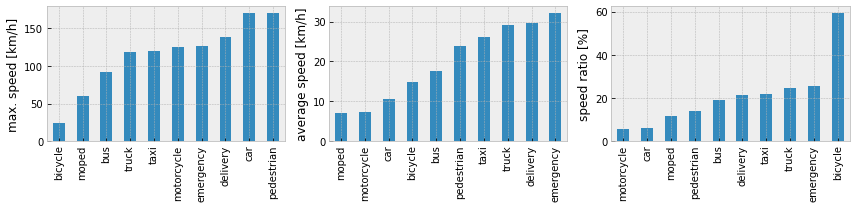

In [13]:
labels = ["max. speed [km/h]", "average speed [km/h]", "speed ratio [%]"]

fig, axes = plt.subplots(nrows=1, ncols=3)
for i,col in enumerate(speed_by_type.columns):
    speed_by_type[col].sort_values().plot.bar(ax=axes[i], figsize=(12,3), xlabel="", ylabel=labels[i])

plt.tight_layout()

OK, before focusing on the following plots let's stop at the first one because there's something really strange: the max. speed and its order among types seems quite reasonable except for... pedestrians are the fastest at all!
Surely something wrong about pedestrians in the dataset! Fastest pedestrians in MoST should not exceed 8 km/h of speed!
How many they are?

In [14]:
n_p = len(data[data['type']=='pedestrian']['ID'].unique())
print(F"{n_p} pedestrians, {n_p/N:.2%} of total number of objects")

19526 pedestrians, 49.22% of total number of objects


A lot! Probably they hide some passengers or whatever? Better try to work on them than directly drop them.
Let's try to infer the type from the corresponding ID with suffix `_tr`, that is meant to be the pedestrian once he's taken a transportation mean. Maybe there's a wrong naming in the ID?

<font color="fuchsia">Machine learning algorithm to classify "false" pedestrians to other types to come next?</font>

In [15]:
grouped = data.groupby('ID')['type']
ped = grouped.min().filter(like='pedestrian', axis=0)

assert ped.equals(grouped.max().filter(like='pedestrian', axis=0)) # sanity check (type unique along time)

def reassign_ped(ID_type):
    if ID_type[1]=='pedestrian':
        try: return ped.loc[ID_type[0]+'_tr']+" (P)"
        except KeyError: return 'pedestrian'
    else: return ID_type[1]

data['type_proc'] = data[['ID', 'type']].apply(reassign_ped, axis=1)

Now let's recreate the tool as before and plot again:

In [17]:
grouped = data.groupby('type_proc')['speed']
speed_by_type = pd.DataFrame({"v_max": grouped.max(), "v_mean": grouped.mean()})
speed_by_type["v_ratio"] = speed_by_type.apply(lambda x: 100*x[1]/x[0], axis=1)

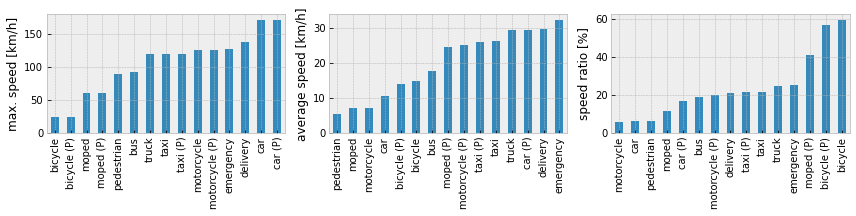

In [18]:
labels = ["max. speed [km/h]", "average speed [km/h]", "speed ratio [%]"]

fig, axes = plt.subplots(nrows=1, ncols=3)
for i,col in enumerate(speed_by_type.columns):
    speed_by_type[col].sort_values().plot.bar(ax=axes[i], figsize=(12,3), xlabel="", ylabel=labels[i])

plt.tight_layout()

Now types are extremely close with respect to the max. speed (less in terms of average speed), but "pure" pedestrians reach still around 90 km/h! We can probably now merge the different types obtained before and finally drop the "true" pedestrians (speed due to teleporting?). Let's check before how many they are:

In [19]:
n_ped = len(data[data['type_proc']=='pedestrian']['ID'].unique())
print(F'{n_ped} "true" pedestrians, {n_ped/n_p:.2%} of total pedestrians')

2447 "true" pedestrians, 12.53% of total pedestrians


In [21]:
data['type_p'] = data['type_proc'].map(lambda x: x.split(' ')[0])
data.drop('type_proc', axis=1, inplace=True)
data = data[data['type_p']!='pedestrian']

And finally plot the tool again:

In [22]:
grouped = data.groupby('type_p')['speed']
speed_by_type = pd.DataFrame({"v_max": grouped.max(), "v_mean": grouped.mean()})
speed_by_type["v_ratio"] = speed_by_type.apply(lambda x: 100*x[1]/x[0], axis=1)

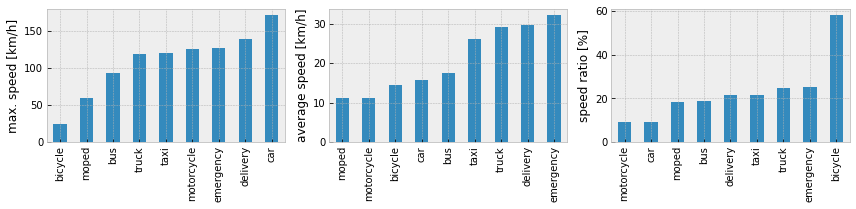

In [23]:
labels = ["max. speed [km/h]", "average speed [km/h]", "speed ratio [%]"]

fig, axes = plt.subplots(nrows=1, ncols=3)
for i,col in enumerate(speed_by_type.columns):
    speed_by_type[col].sort_values().plot.bar(ax=axes[i], figsize=(12,3), xlabel="", ylabel=labels[i])

plt.tight_layout()

<font color="blue">Further analysis based on this starting point to come...</font>

Buses and coaches keep stopping, thus they do not represent traffic very well; let's drop them:

In [137]:
data = data[(data['type']!='bus') & (data['type']!='coach')]

In [132]:
#real_ped['other_type'] = real_ped.index.map(mappa)
#fig, axes = plt.subplots(nrows=3, ncols=1)
#for i,j in enumerate(np.random.randint(0, army.shape[0], 3)):
#    army.iloc[j].T.plot(ax=axes[i], figsize=(15,5))